In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable

# from torchsummary import summary
from torch.utils.data import Dataset
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from glob import glob
import os

from torch.utils.data import DataLoader

from tqdm import tqdm

In [2]:
#get SAM model
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/bin/bash: {sys.executable}: command not found
--2024-10-04 09:01:34--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.108, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: 'sam_vit_h_4b8939.pth'

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   280MB/s    in 8.8s    

2024-10-04 09:01:43 (279 MB/s) - 'sam_vit_h_4b8939.pth' saved [2564550879/2564550879]



In [3]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [4]:
def get_binary_mask(anns):
    if len(anns) == 0:
        print('none')
        return None
    
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    mask_shape = sorted_anns[0]['segmentation'].shape
    
    binary_mask = np.zeros(mask_shape, dtype=np.uint8)
    
    for ann in sorted_anns:
        m = ann['segmentation']
        binary_mask[m] = 1
     
    return binary_mask

In [5]:
def get_intersection_area(bbox1, bbox2):
    x1, y1, x2, y2 = bbox1
    x3, y3, x4, y4 = bbox2
    x_overlap = max(0, min(x2, x4) - max(x1, x3))
    y_overlap = max(0, min(y2, y4) - max(y1, y3))
    return x_overlap * y_overlap

In [6]:
def list_to_numpy(lst):
    return np.array(lst)

In [7]:
def numpy_to_list(np_array):
    return np_array.tolist()

In [10]:
def otsu_threshold(label_image, original_image):
    """Apply Otsu's thresholding to an image

    Args:
        label_image: The label image
        original_image: The original image

    Returns:
        The thresholded image
    """

    # Convert the label image to grayscale
    label_gray = cv2.cvtColor(label_image, cv2.COLOR_BGR2GRAY)

    # Convert the original image to grayscale
    original_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Read the label image
    label_array = np.array(label_gray)

    # Read the original image
    original_array = np.array(original_gray)

    # Calculate the mean value of pixels where label_array == 0
    mean_value_label_zero = np.mean(original_array[label_array != 0])

    # Calculate the overall mean value of original_array
    mean_value_overall = np.mean(original_array)
    


    # Invert the label_array if mean_value_label_zero < mean_value_overall
    if mean_value_label_zero < mean_value_overall:
        pixel_para = 255
    else:
        pixel_para = 0

    # Mask out the pixels where the label image is 0
    result_array = np.where(label_array == 0, original_gray, 255 - pixel_para)

    # Calculate the histogram of the masked image
    hist = cv2.calcHist([result_array], [0], None, [256], [0, 256])

    # Normalize the histogram
    hist = hist / hist.sum()

    # Apply Otsu's thresholding
    thresh, _ = cv2.threshold(original_gray, 0, 255, cv2.THRESH_OTSU)

    thresh = int(thresh *  (1 -  (mean_value_label_zero - mean_value_overall) / 255))
    binary = cv2.threshold(result_array, thresh, 255, cv2.THRESH_BINARY)[1]
    
    if pixel_para == 255:
        binary = 255 - binary
        
    binary = np.maximum(binary, label_array)

    return binary

# **RUN**

In [11]:
input_folder = '/kaggle/input/uhcsdataset/uhcs_dataset/Images'

In [12]:
SAM_threshold_foreground = 0.9
SAM_threshold_background = 0.7
class_remove_precent = 0.2
remove_precent = 0.3

In [13]:
#parameters
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side =64,
    pred_iou_thresh=SAM_threshold_foreground,
    stability_score_thresh=SAM_threshold_foreground,
)

In [14]:
# JSON file
import json

# Get all files in the input folder
image_files = os.listdir(input_folder)

# Create an empty dictionary to store the original masks
json_masks = {}

SAM_folder = '/kaggle/working/SAM_raw'

# Create output folder
os.makedirs(SAM_folder, exist_ok=True)

# Process each file
for image_file in tqdm(image_files):
    # Construct the complete path for input and output files
    input_path = os.path.join(input_folder, image_file)

    # Perform your image processing operations here, for example, using the PIL library
    image = cv2.imread(input_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_raw = mask_generator.generate(image)

    # Find the indices of bounding boxes with an area greater than half the image area
    height, width, _ = image.shape
    image_area = height * width
    remove_area_indices = [i for i, mask in enumerate(mask_raw) if mask['area'] > image_area / 3]

    # Remove the elements corresponding to bounding boxes that are larger than half the image area (using reversed)
    for i in reversed(remove_area_indices):
        del mask_raw[i]

    # Process overlapping masks, keeping only the smallest mask
    mask_processed = []
    for mask in mask_raw:
        x, y, w, h = mask['bbox']
        bbox = (x, y, x + w, y + h)
        overlapping = False
        for processed_mask in mask_processed:
            px, py, pw, ph = processed_mask['bbox']
            pbbox = (px, py, px + pw, py + ph)
            if get_intersection_area(bbox, pbbox) > 0 and mask['area'] > processed_mask['area']:
                overlapping = True
                break
        if not overlapping:
            mask_processed.append(mask)

    # Generate output file name
    base_name, ext = os.path.splitext(image_file)
    json_filename = f'{base_name}.json'
#     json_path = os.path.join(json_output_folder, json_filename)

    processed_masks = []
    for mask in mask_processed:
        processed_mask = {
            'segmentation': (mask['segmentation']),
            'area': mask['area'],
            'bbox': mask['bbox'],
            'predicted_iou': mask['predicted_iou'],
            'point_coords': mask['point_coords'],
            'stability_score': mask['stability_score'],
            'crop_box': mask['crop_box']
        }
        processed_masks.append(processed_mask)

    json_masks[image_file] = processed_masks
    
    binary_mask = get_binary_mask(mask_processed)
    if binary_mask is not None:
        # Multiply binary_mask by 255 to get the final mask image
        mask_image = binary_mask * 255
    else:
        # Handle the case where binary_mask is None
        print("Error: get_binary_mask() returned None.")
    
    # Save the binary mask image
    output_path = os.path.join(SAM_folder, f"{base_name}.png")
    cv2.imwrite(output_path, mask_image)


100%|██████████| 3/3 [00:44<00:00, 14.99s/it]


### Dataset-level Clustering

In [15]:

# Image folder path
image_folder = input_folder

## Calculate distance
means = []
stddevs = []

# Iterate over JSON files
for json_file, masks in tqdm(json_masks.items()):
    # Get the JSON file name (without the extension)
    base_name = os.path.splitext(json_file)[0]
    
    # Construct the image file path
    image_path = os.path.join(image_folder, json_file)
    
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    image = cv2.equalizeHist(image)
    
    # Gaussian blur
    image = cv2.GaussianBlur(image, (3, 3), 0)
    
    # Create a black background
    mask_image = np.zeros_like(image)
    
    # For each mask
    for i, mask in enumerate(masks):
        # Get the mask array
        mask_array = mask['segmentation']
    
        # Set the mask area to the original image's values
        mask_image[mask_array] = image[mask_array]
        
        # Calculate the mean and standard deviation of the grayscale values
        mean = np.mean(mask_image[mask_array])
        stddev = np.std(mask_image[mask_array])
        
        # Append the mean and standard deviation to the lists
        means.append(mean)
        stddevs.append(stddev)
        
# Calculate the cluster center
overall_mean = sum(means) / len(means)
overall_stddev = sum(stddevs) / len(stddevs)
cluster_center = (overall_mean, overall_stddev)
    
# Calculate the distance from each point to the cluster center
distances_all = []
for mean, stddev in zip(means, stddevs):
    dist = np.sqrt((mean - cluster_center[0])**2 + (stddev - cluster_center[1])**2)
    distances_all.append(dist)
    
# Sort the distances
sorted_distances_all = sorted(distances_all)


100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


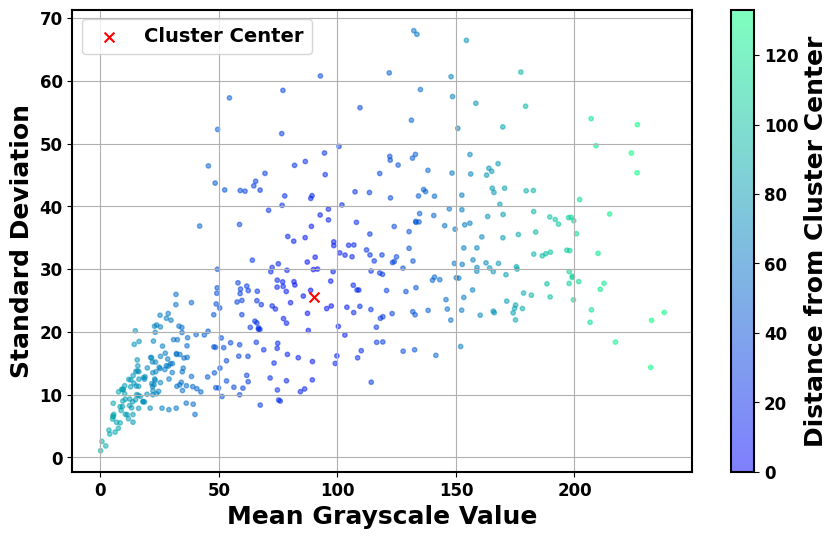

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Arial'  # Set font to Arial
mpl.rcParams['font.weight'] = 'bold'  # Set font to bold
mpl.rcParams['font.size'] = 12  # Set font size to 12
mpl.rcParams['axes.linewidth'] = 1.5  # Set the linewidth of the outer box to 1.5

# Set the size and title of the figure
plt.figure(figsize=(10, 6))

# Calculate the distance from the farthest point to the cluster center
max_distance = max(sorted_distances_all)

# Plot scatter plot, using color to encode distance, and adjust point size and transparency
scatter = plt.scatter(means, stddevs, c=distances_all, cmap="winter", vmin=0 * max_distance, vmax=0.9 * max_distance, s=10, alpha=0.5)

# Add the cluster center point
plt.scatter(cluster_center[0], cluster_center[1], s=50, marker='x', c='r', label='Cluster Center')

# Add color bar
cbar = plt.colorbar(scatter)
cbar.ax.yaxis.label.set_weight('bold')  # Set the color bar label to bold
cbar.set_label("Distance from Cluster Center", size=18)  # Set the color bar label

# Add axis labels and grid lines
plt.xlabel("Mean Grayscale Value", size=18, fontweight='bold')  # x-axis label
plt.ylabel("Standard Deviation", size=18, fontweight='bold')  # y-axis label
plt.grid(True)  # Add grid lines

# Add legend
plt.legend(loc='upper left', fontsize=14)

plt.savefig('/kaggle/working/image_statistics.svg', format='svg')  # Save the figure as SVG format
# Display the figure
plt.show()



In [20]:
def convert_to_three_channel(image_path):
    # Read the image
    image = np.array(Image.open(image_path))
    
    # Check if the image is a binary image
    if image.ndim == 2:
        # If it's a binary image, convert it to a 3-channel image
        three_channel_image = np.dstack((image, image, image))
    else:
        # If it's not a binary image, return the original image
        three_channel_image = image
        
    return three_channel_image
    
def compute_iou_precision_recall(predicted_image_path, ground_truth_image_path):
    # Read the predicted image and ground truth image
    predicted_image = np.array(convert_to_three_channel(predicted_image_path))
    ground_truth_image = np.array(convert_to_three_channel(ground_truth_image_path))
   
    # Ensure that the predicted image and ground truth image have the same size
    if predicted_image.shape != ground_truth_image.shape:
        print(predicted_image.shape)
        print(ground_truth_image.shape)
        raise ValueError("The size of the predicted image and ground truth image does not match")

    # Convert the predicted image and ground truth image to boolean arrays
    predicted_binary = (predicted_image > 0)
    ground_truth_binary = (ground_truth_image > 0)

    # Compute the intersection
    intersection = np.logical_and(predicted_binary, ground_truth_binary)

    # Compute the union
    union = np.logical_or(predicted_binary, ground_truth_binary)

    # Compute the IoU value
    iou = np.sum(intersection) / np.sum(union)

    # Compute Precision and Recall
    true_positive = np.sum(np.logical_and(predicted_binary, ground_truth_binary))
    false_positive = np.sum(np.logical_and(predicted_binary, np.logical_not(ground_truth_binary)))
    false_negative = np.sum(np.logical_and(np.logical_not(predicted_binary), ground_truth_binary))
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    return iou, precision, recall

### Image-level clustering

In [22]:


output_folder = '/kaggle/working/SAMFG'

# Create output folder
os.makedirs(output_folder, exist_ok=True)

for json_file, masks in tqdm(json_masks.items()):
    
    # Get the JSON file name (without the extension)
    base_name = os.path.splitext(json_file)[0]
    
    # Construct the image file path
    image_path = os.path.join(image_folder, json_file)
    
#     print(image_path)
    
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    image = cv2.equalizeHist(image)
    
    # Gaussian blur
    image = cv2.GaussianBlur(image, (3, 3), 0)
    
    # Create a black background
    mask_image = np.zeros_like(image)
    
    # For each mask
    filtered_masks = []
    for i, mask in enumerate(masks):
        # Get the mask array
        mask_array = mask['segmentation']

        # Set the mask area to the values of the original image
        mask_image[mask_array] = image[mask_array]

        # Calculate the mean and standard deviation of the grayscale
        mean = np.mean(mask_image[mask_array])
        stddev = np.std(mask_image[mask_array])
        
        dist = np.sqrt((mean - cluster_center[0])**2 + (stddev - cluster_center[1])**2)
        if dist < min_distance_threshold:
            filtered_masks.append(mask)

    masks = filtered_masks
    
    means = []
    stddevs = []
    # For each mask
    for i, mask in enumerate(masks):
        # Get the mask array
        mask_array = mask['segmentation']
    
        # Set the mask area to the values of the original image
        mask_image[mask_array] = image[mask_array]
        
        # Calculate the mean and standard deviation of the grayscale
        mean = np.mean(mask_image[mask_array])
        stddev = np.std(mask_image[mask_array])
        
        # Add the mean and standard deviation to the lists
        means.append(mean)
        stddevs.append(stddev)
        
    # If there are no valid mask areas, skip this image
    if len(means) == 0:
        print(image_path)
        print(masks)
        continue
    
    # Calculate the cluster center
    overall_mean = sum(means) / len(means)
    overall_stddev = sum(stddevs) / len(stddevs)
    cluster_center = (overall_mean, overall_stddev)
    
    # Calculate the distance from each point to the cluster center
    distances = []
    for mean, stddev in zip(means, stddevs):
        dist = np.sqrt((mean - cluster_center[0])**2 + (stddev - cluster_center[1])**2)
        distances.append(dist)
    
    # Sort the distances
    sorted_distances = sorted(distances)
    
    # Remove the farthest 10% of masks
    if len(masks) > 10:
        num_masks_to_remove = max(1, int(len(masks) * remove_precent))
        masks_to_remove = sorted_distances[-num_masks_to_remove:]

        # Remove the farthest masks from the mask list
        masks = [mask for mask, dist in zip(masks, distances) if dist not in masks_to_remove]

    binary_mask = get_binary_mask(masks)
    if binary_mask is not None:
        # Multiply binary_mask by 255 to get the final mask image
        mask_image = binary_mask * 255
    else:
        # Handle the case where binary_mask is None
        print("Error: get_binary_mask() returned None.")
    
    # Save the binary mask image
    output_path = os.path.join(output_folder, f"{base_name}.png")
    cv2.imwrite(output_path, mask_image)  
  
    
    


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


# **Background:**

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side =64,
    pred_iou_thresh=SAM_threshold_background,
    stability_score_thresh=SAM_threshold_background,
#     crop_n_layers=1,
)

In [ ]:
# JSON files
import json

# Set input and output folder paths
# input_folder = '/kaggle/input/temcdataset/TEMCdataset/images'

output_folder = '/kaggle/working/overlay_BG'

# Get all files in the input folder
image_files = os.listdir(input_folder)

# Create output folder
os.makedirs(output_folder, exist_ok=True)

# Create an empty dictionary to store original masks
json_masks = {}

# Iterate over each file and process it
for image_file in tqdm(image_files):
    # Construct the complete paths for input and output files
    input_path = os.path.join(input_folder, image_file)

    # Load the image
    image = cv2.imread(input_path)
    
    mask_raw = mask_generator.generate(image)

    # Find the indices of bounding boxes with an area greater than half of the image area
    height, width, _ = image.shape
    image_area = height * width
    large_area_indices = [i for i, mask in enumerate(mask_raw) if mask['area'] > image_area / 3]

    # Delete the elements corresponding to bounding boxes with an area greater than half of the image area (using reversed)
    for i in reversed(large_area_indices):
        del mask_raw[i]

    # Generate output file name
    base_name, ext = os.path.splitext(image_file)
    json_filename = f'{base_name}.json'
#     json_path = os.path.join(json_output_folder, json_filename)
    
    binary_mask = get_binary_mask(mask_raw)
    binary_label = binary_mask * 255
    
    # Generate output file name
    base_name, ext = os.path.splitext(image_file)
    result_filename = f'{base_name}.png'
    result_path = os.path.join(output_folder, result_filename)

    # Save the processed image
    seg_pil = Image.fromarray(binary_mask * 255)
    seg_pil.save(result_path)

print("Image processing completed and saved in", output_folder)
